In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # vecinos más cercanos para clasificación
from sklearn.metrics import accuracy_score # métrica de evaluación
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import numpy as np

df = pd.read_csv('../datasets/smokers.csv')
df = df[['triglyceride', 'Gtp', 'hemoglobin', 'serum creatinine', 'smoking']]
X = df.drop(['smoking'], axis=1)
y = df['smoking']

Estarán de acuerdo que en terminos de Exactitud hemos conseguido el mejor resultado posible (Si logran mejores valores nos avisan!)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler_X = StandardScaler(with_mean=True, with_std=True)
scaler_X.fit(X_train) # entrenamos los valores quitandole la variable clase
X_train.loc[:,X_train.columns] = scaler_X.transform(X_train)
X_test.loc[:,X_test.columns] = scaler_X.transform(X_test)
model = KNeighborsClassifier(metric='euclidean', n_neighbors=69, weights='distance')
model.fit(X_train,y_train) # Entrenamos el clasificador
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.81      0.82      0.82      7400
           1       0.69      0.67      0.68      4296

    accuracy                           0.77     11696
   macro avg       0.75      0.74      0.75     11696
weighted avg       0.76      0.77      0.76     11696



Con mucho esfuerzo :) logramos un accuracy de 0.77

Modificamos el dataset, que es conocido por nosotros para hacer que una clase sea prevalente sobre la otra

<Axes: xlabel='smoking', ylabel='count'>

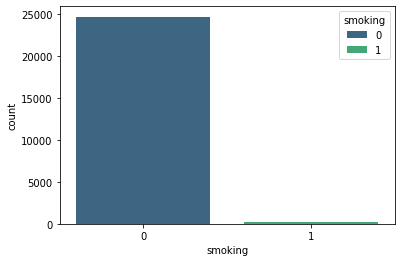

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(sampling_strategy={1: 200}, random_state=42)
X_res, y_res = rus.fit_resample(X, y)
df_res = pd.DataFrame(pd.concat([X_res, y_res], axis=1), columns=df.columns)
sns.countplot(x='smoking', data=df_res, hue='smoking', palette='viridis')

El accuracy es excelente, pero ¿me sirve?

In [11]:
X = df_res.drop(['smoking'], axis=1)
y = df_res['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler_X = StandardScaler(with_mean=True, with_std=True)
scaler_X.fit(X_train) # entrenamos los valores quitandole la variable clase
X_train.loc[:,X_train.columns] = scaler_X.transform(X_train)
X_test.loc[:,X_test.columns] = scaler_X.transform(X_test)
model = KNeighborsClassifier(metric='euclidean', n_neighbors=69, weights='distance')
model.fit(X_train,y_train) # Entrenamos el clasificador
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7400
           1       0.00      0.00      0.00        60

    accuracy                           0.99      7460
   macro avg       0.50      0.50      0.50      7460
weighted avg       0.98      0.99      0.99      7460



¿Que puedo hacer? El modelo es muy simple (KNN) y ademas con muy pocas columnas. Respuesta: Underfitting.

<Axes: xlabel='smoking', ylabel='count'>

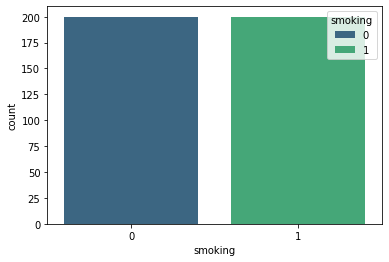

In [12]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_res, y_res = rus.fit_resample(X, y)
df_res = pd.DataFrame(pd.concat([X_res, y_res], axis=1), columns=df.columns)
sns.countplot(x='smoking', data=df_res, hue='smoking', palette='viridis')

In [13]:
X = df_res.drop(['smoking'], axis=1)
y = df_res['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler_X = StandardScaler(with_mean=True, with_std=True)
scaler_X.fit(X_train) # entrenamos los valores quitandole la variable clase
X_train.loc[:,X_train.columns] = scaler_X.transform(X_train)
X_test.loc[:,X_test.columns] = scaler_X.transform(X_test)
model = KNeighborsClassifier(metric='euclidean', n_neighbors=69, weights='distance')
model.fit(X_train,y_train) # Entrenamos el clasificador
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71        60
           1       0.70      0.82      0.75        60

    accuracy                           0.73       120
   macro avg       0.74      0.73      0.73       120
weighted avg       0.74      0.73      0.73       120

